# Implementation of Test Framework for PathFinding Algo

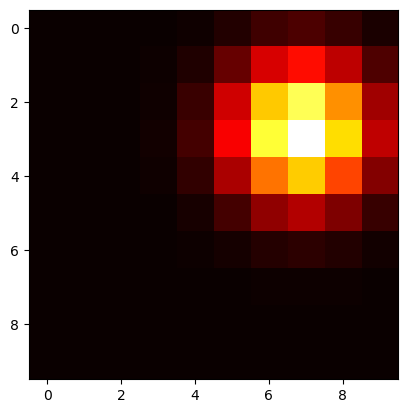

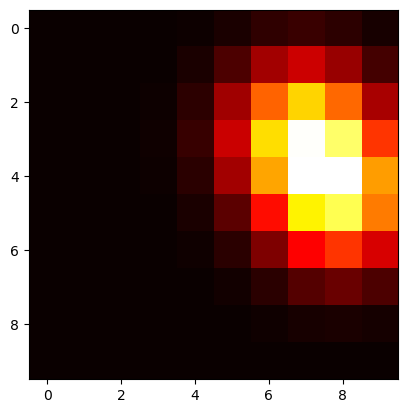

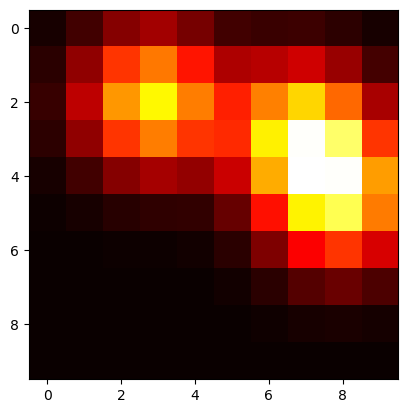

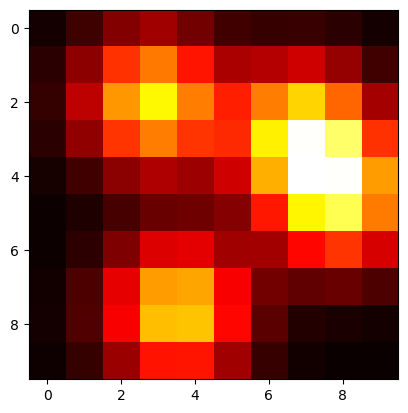

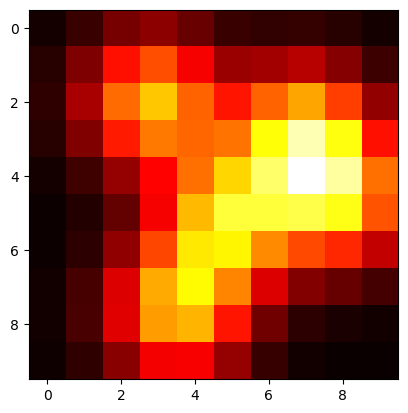

[[0.01865329 0.07365672 0.16235715 0.20038242 0.14273561 0.07546871
  0.06276013 0.06618827 0.04594296 0.01829299]
 [0.04486125 0.17717587 0.39081765 0.4841919  0.35421135 0.21881288
  0.23140313 0.26195359 0.18696367 0.07739714]
 [0.06020913 0.2380394  0.52696865 0.66203833 0.51603437 0.39864306
  0.51385449 0.61384268 0.4618862  0.20807109]
 [0.04521544 0.17997402 0.40706072 0.54742419 0.51840111 0.53861508
  0.75211389 0.9227885  0.75941766 0.39163514]
 [0.01957112 0.08162299 0.20869163 0.37126223 0.53570205 0.68695092
  0.85151717 1.         0.90474963 0.53352666]
 [0.00727446 0.03848371 0.13821336 0.35544204 0.64300513 0.80403533
  0.80164369 0.82038491 0.76820956 0.48921842]
 [0.00904071 0.05521993 0.20318997 0.47068758 0.71473643 0.73402437
  0.57431524 0.47474256 0.4232456  0.2751086 ]
 [0.0157374  0.09331196 0.31536113 0.62075414 0.73891826 0.56432725
  0.31419451 0.18371163 0.14092691 0.08985039]
 [0.01680403 0.09835951 0.32298477 0.59871528 0.63479782 0.39591954
  0.15685628

Map(center=[1.3411999741511156, 103.96292463247435], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [1]:
from ipyleaflet import Map, Marker, Icon, Circle, Rectangle
import random
import numpy as np
import matplotlib.pyplot as plt

class PathFindingVisualizer:
    def __init__(self):
        self.map = None
        self.bounding_box = None
        self.probability_map = None
        self.casualty_locations = []

    def load_map(self, latitude, longitude, zoom_start=20):  # Adjust zoom level as needed
        self.map = Map(center=[latitude, longitude], zoom=zoom_start)
        self.bounding_box = self.calculate_bounding_box(latitude, longitude, zoom_start)
        return self.bounding_box

    def calculate_bounding_box(self, lat, lon, zoom):
        # Calculate bounding box based on the central marker's location
        half_side = 40075016 / 2 ** (zoom - 1)  # Earth's circumference divided by 2^(zoom-1)
        lat_deg_per_meter = 360 / (2 * np.pi * 6371000)
        lon_deg_per_meter = 360 / (2 * np.pi * 6371000 * np.cos(lat * np.pi / 180))
        
        min_lat = lat - (half_side / 2) * lat_deg_per_meter
        max_lat = lat + (half_side / 2) * lat_deg_per_meter
        min_lon = lon - (half_side / 2) * lon_deg_per_meter
        max_lon = lon + (half_side / 2) * lon_deg_per_meter
        
        return (min_lat, min_lon, max_lat, max_lon)

    def generate_probability_map(self, num_hotspots):
        if self.bounding_box is None:
            raise ValueError("Bounding box not available. Please load a map first.")

        def gaus2d(x=0, y=0, mx=0, my=0, sx=0.0001, sy=0.0001):
            return 1. / (2. * np.pi * sx * sy) * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))

        min_lat, min_lon, max_lat, max_lon = self.bounding_box

        num_regions = 100  # Total number of regions
        side_length = int(num_regions ** 0.5) 
        self.probability_map = np.zeros((side_length, side_length))

        for _ in range(num_hotspots):
            mx = random.uniform(min_lat, max_lat)
            my = random.uniform(min_lon, max_lon)
            x = np.linspace(min_lat, max_lat, side_length)
            y = np.linspace(min_lon, max_lon, side_length)
            x, y = np.meshgrid(x, y)
            hotspot = gaus2d(x, y, mx, my)
            self.probability_map += hotspot
            plt.imshow(self.probability_map, cmap='hot', interpolation='nearest')
            plt.show()

        self.probability_map /= np.max(self.probability_map)  # Normalize
        print(self.probability_map)
        return self.probability_map

    def generate_casualties(self, num_casualties):
        if self.probability_map is None:
            raise ValueError("Probability map not generated. Please generate it first.")

        casualty_locations = []
        side_length = len(self.probability_map)

        while len(casualty_locations) < num_casualties:
            x = random.randint(0, side_length - 1)
            y = random.randint(0, side_length - 1)
            probability = random.uniform(0, 1)

            if probability < self.probability_map[x, y]:
                lat, lon = self.coordinates_from_region(x, y)
                casualty_locations.append((lat, lon))

        self.casualty_locations = casualty_locations
        return casualty_locations

    def run_path_finding(self):
        pass

    def visualize_map(self):
        if self.map is None:
            raise ValueError("Map not loaded. Please load a map first.")

        for lat, lon in self.casualty_locations:
            marker = Marker(location=[lat, lon])
            self.map.add_layer(marker)

        # Add a bounding box to the map
        min_lat, min_lon, max_lat, max_lon = self.bounding_box
        rectangle = Rectangle(bounds=((min_lat, min_lon), (max_lat, max_lon)), color="blue", weight=2, fill_opacity=0)
        self.map.add_layer(rectangle)

        display(self.map)

    def coordinates_from_region(self, x, y):
        # Calculate latitude and longitude from region coordinates
        if self.bounding_box is None:
            raise ValueError("Bounding box not available.")
        
        min_lat, min_lon, max_lat, max_lon = self.bounding_box
        lat = min_lat + (max_lat - min_lat) * (x / self.probability_map.shape[0])
        lon = min_lon + (max_lon - min_lon) * (y / self.probability_map.shape[1])
        return lat, lon

# Example usage:
visualizer = PathFindingVisualizer()
visualizer.load_map(1.3411999741511156, 103.96292463247435)  # SUTD coordinates
visualizer.generate_probability_map(5)
casualty_locations = visualizer.generate_casualties(5)
print(casualty_locations)
visualizer.visualize_map()
